开始数据预处理...
CSV 文件 '20170802.csv' 已读取. DataFrame 的前几行 (原始):
                    时间   小石棚   孟家店   矿洞沟   太平庄   西扒山    茧场   大姜屯   桂云花    天益  \
0                   权重  0.08  0.09  0.16  0.08  0.11  0.11  0.11  0.08  0.11   
1  2017-08-02 05:00:00  0.00  0.00  2.00  4.50  0.00  1.20  0.50  1.50  1.00   
2  2017-08-02 08:00:00  0.00  0.00  1.50  1.00  0.00  1.00  1.50  0.00  0.00   
3  2017-08-02 11:00:00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  2.00  0.00   
4  2017-08-02 14:00:00  0.00  0.50  0.00  0.00  0.50  0.00  0.50  0.00  0.00   

     大坝  算数平均面雨量  泰森多边形面雨量  实测流量  修正流量  退水曲线  分割流量  
0  0.06      NaN       NaN   NaN   NaN   NaN   NaN  
1  0.90     1.16     1.167  10.0  10.0  10.0   0.0  
2  0.10     0.51     0.595  10.0  10.0  10.0   0.0  
3  0.00     0.20     0.167  11.0  11.0  10.0   1.0  
4  0.00     0.15     0.157  11.0  11.0  10.0   1.0  
DataFrame 的列名 (原始): ['时间', '小石棚', '孟家店', '矿洞沟', '太平庄', '西扒山', '茧场', '大姜屯', '桂云花', '天益', '大坝', '算数平均面雨量', '泰森多边形面雨量', '实测流量', '修正流量', '退水曲线', '

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12692\4040767674.py:228: UserWarning: Glyph 179 (\N{SUPERSCRIPT THREE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.92]); plt.show()
d:\Anaconda\envs\condaenvironment\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 179 (\N{SUPERSCRIPT THREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


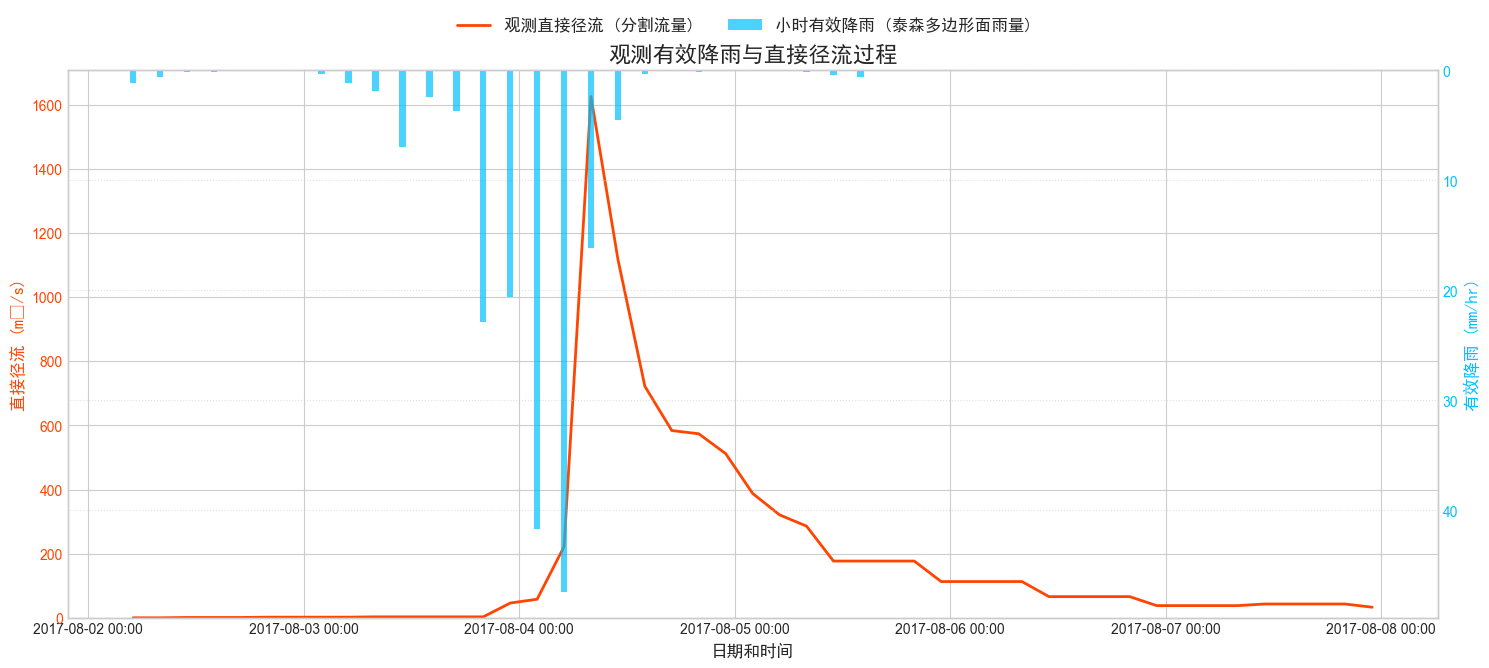

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12692\4040767674.py:273: UserWarning: Glyph 179 (\N{SUPERSCRIPT THREE}) missing from current font.
  plt.legend(prop=font); plt.grid(True, linestyle=':', alpha=0.6); plt.tight_layout(); plt.show()
d:\Anaconda\envs\condaenvironment\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 179 (\N{SUPERSCRIPT THREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)



正在推求单位线...
  调试：P_blocks_trimmed 的长度 (num_rain_blocks): 47
  调试：Q_obs_trimmed_for_derivation 的长度 (num_runoff_ordinates): 47
  调试：steps_per_D_block: 1
  调试：估算的 max_uh_len (num_runoff_ordinates - (num_rain_blocks - 1) * steps_per_D_block): 1
单位线推求消息: 成功

正在绘制推求的单位线图...


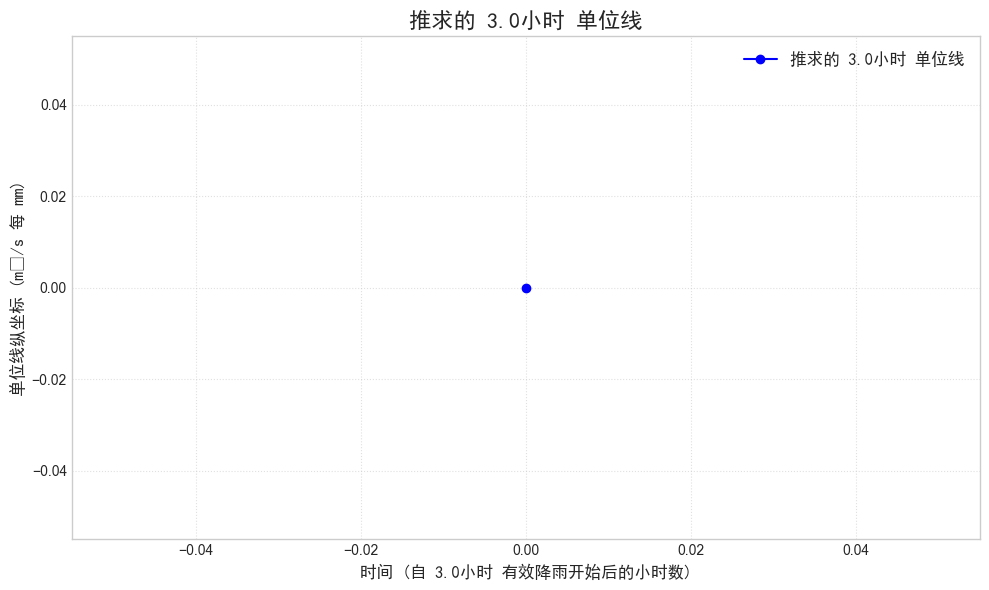


正在使用推求的单位线模拟径流...

正在绘制观测径流与模拟径流的对比图...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12692\4040767674.py:305: UserWarning: Glyph 179 (\N{SUPERSCRIPT THREE}) missing from current font.
  plt.grid(True, linestyle=':', alpha=0.6); plt.tight_layout(); plt.show()
d:\Anaconda\envs\condaenvironment\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 179 (\N{SUPERSCRIPT THREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


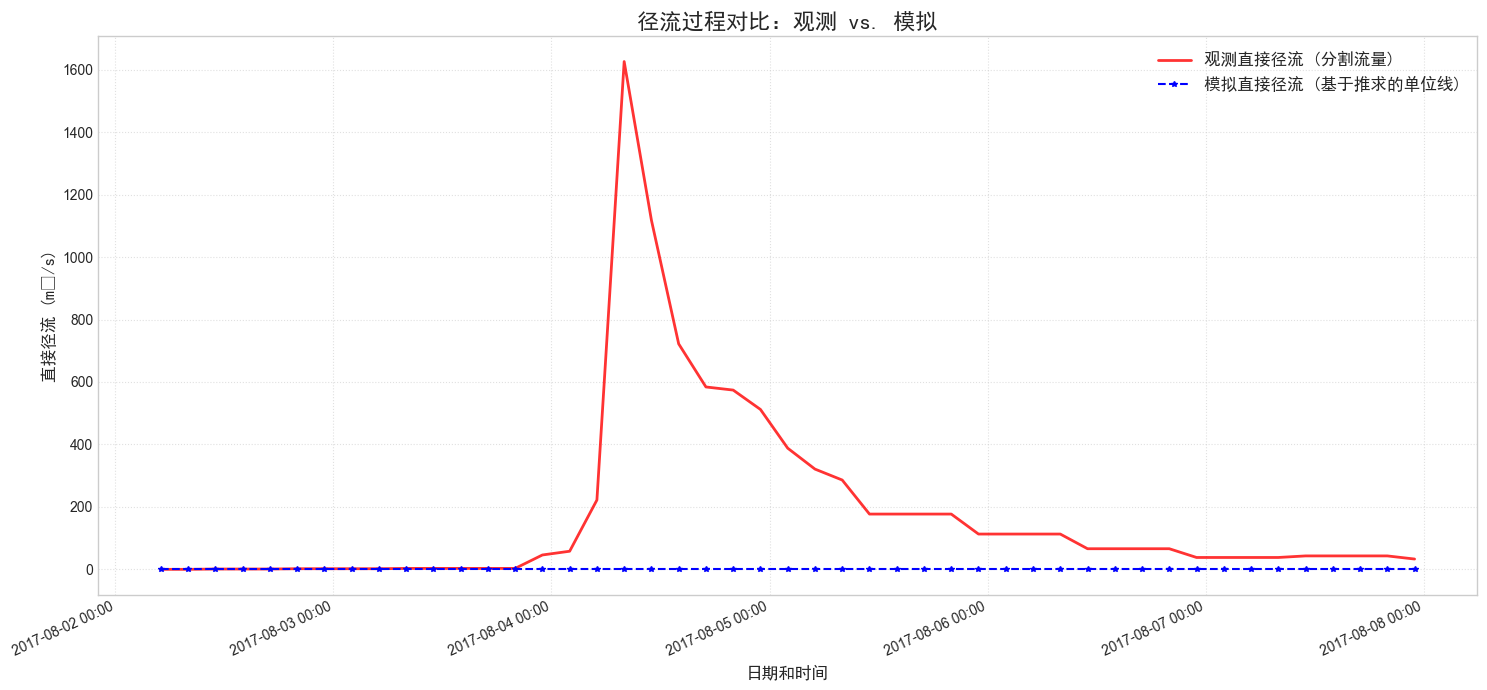

ValueError: Invalid format specifier

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties # 用于中文字体

# --- 用于支持中文显示的字体设置 ---
try:
    font = FontProperties(fname=None, family='SimHei', size=12)
except RuntimeError:
    print("警告：找不到SimHei字体，将使用默认字体，中文可能显示为方框。")
    print("请尝试安装SimHei字体或修改为系统中已有的中文字体。")
    font = FontProperties(size=12)

# --- 函数定义区 ---
def derive_uh_from_complex_storm_iterative(
    observed_total_direct_runoff_m3s,
    effective_rainfall_blocks_mm,
    time_step_runoff_hours,
    unit_hydrograph_duration_hours
):
    msg = "成功"
    num_rain_blocks = len(effective_rainfall_blocks_mm)
    num_runoff_ordinates = len(observed_total_direct_runoff_m3s)
    steps_per_D_block = int(round(unit_hydrograph_duration_hours / time_step_runoff_hours))

    if steps_per_D_block == 0:
        msg = "错误：单位线时段小于或等于径流数据时间步长。"
        return None, None, msg
    if num_rain_blocks == 0:
        msg = "错误：有效降雨块序列为空。"
        return None, None, msg
    if num_runoff_ordinates == 0:
        msg = "错误：观测径流序列为空。"
        return None, None, msg

    max_uh_len = num_runoff_ordinates - (num_rain_blocks - 1) * steps_per_D_block
    if max_uh_len <= 0:
        msg = "错误：对于给定的降雨块和单位线时段，径流数据过短。"
        return None, None, msg # <--- 这里是您遇到的错误

    uh_ordinates = np.zeros(max_uh_len)
    first_P_val = effective_rainfall_blocks_mm[0]
    if first_P_val <= 1e-6:
        msg = "错误：第一个有效降雨块P1必须显著大于零才能使用此简化迭代法。"
        return None, None, msg

    for k in range(max_uh_len):
        if k >= num_runoff_ordinates: continue
        sum_known_terms = 0
        for i in range(1, num_rain_blocks):
            uh_index_needed = k - i * steps_per_D_block
            if uh_index_needed >= 0 and uh_index_needed < k:
                sum_known_terms += effective_rainfall_blocks_mm[i] * uh_ordinates[uh_index_needed]
        if k < num_runoff_ordinates:
            residual_q = observed_total_direct_runoff_m3s[k] - sum_known_terms
            if abs(first_P_val) > 1e-6: uh_ordinates[k] = residual_q / first_P_val
            else:
                uh_ordinates[k] = 0
                if msg == "成功": msg = "警告：在单位线计算中遇到P1除零错误。"
        else:
            if abs(first_P_val) > 1e-6: uh_ordinates[k] = -sum_known_terms / first_P_val
            else: uh_ordinates[k] = 0
    negative_ordinates_sum = np.sum(uh_ordinates[uh_ordinates < -1e-6])
    positive_ordinates_sum = np.sum(uh_ordinates[uh_ordinates > 0])
    if positive_ordinates_sum > 1e-6 and negative_ordinates_sum < -0.05 * positive_ordinates_sum:
        if msg == "成功": msg = "警告：单位线中发现显著负值。"
    time_axis_uh = np.arange(len(uh_ordinates)) * time_step_runoff_hours
    return uh_ordinates, time_axis_uh, msg

def apply_unit_hydrograph_convolution(
    unit_hydrograph_ordinates,
    effective_rainfall_blocks_mm,
    time_step_hours,
    uh_duration_hours
):
    num_rain_blocks = len(effective_rainfall_blocks_mm)
    len_uh = len(unit_hydrograph_ordinates)
    steps_per_D_block = int(round(uh_duration_hours / time_step_hours))
    if steps_per_D_block == 0: steps_per_D_block = 1
    simulated_drh_len = len_uh + (num_rain_blocks - 1) * steps_per_D_block
    if simulated_drh_len <=0:
        print("警告：计算得到的模拟径流长度为0或负，返回空数组。")
        return np.array([]), np.array([])
    simulated_drh = np.zeros(simulated_drh_len)
    for i, p_eff_block in enumerate(effective_rainfall_blocks_mm):
        if p_eff_block > 0:
            scaled_uh = unit_hydrograph_ordinates * p_eff_block
            start_index = i * steps_per_D_block
            if start_index < len(simulated_drh):
                actual_len_to_add = min(len(scaled_uh), len(simulated_drh) - start_index)
                simulated_drh[start_index : start_index + actual_len_to_add] += scaled_uh[:actual_len_to_add]
    time_axis_sim_drh = np.arange(len(simulated_drh)) * time_step_hours
    return simulated_drh, time_axis_sim_drh
# --- 函数定义结束 ---

# --- 参数配置 ---
csv_file_path = '20170802.csv'
time_col_name = '时间'
rain_col_idx = 12
flow_col_idx = 16
standard_datetime_col_name = 'datetime_std'
unit_hydrograph_D_hours = 3.0
runoff_dt_hours = 3.0

# --- 初始化变量 ---
df = None
P_blocks_trimmed = None
Q_obs_trimmed_for_derivation = None
time_Q_obs_trimmed_start_datetime = None
hourly_effective_rainfall_mm = None
observed_direct_runoff_m3s_np = None
data_preprocessing_successful = False

# --- 1. 数据预处理 ---
print("开始数据预处理...")
try:
    try:
        df = pd.read_csv(csv_file_path, header=0)
    except UnicodeDecodeError:
        df = pd.read_csv(csv_file_path, header=0, encoding='gbk')
    
    print(f"CSV 文件 '{csv_file_path}' 已读取. DataFrame 的前几行 (原始):")
    print(df.head())
    print("DataFrame 的列名 (原始):", df.columns.tolist())

    if time_col_name not in df.columns:
        raise KeyError(f"列 '{time_col_name}' 不存在于CSV文件中。实际列名: {df.columns.tolist()}")

    if not df.empty and df[time_col_name].iloc[0] == '权重':
        print(f"发现第一行数据在 '{time_col_name}' 列的值为 '权重'，将删除此行。")
        df = df.iloc[1:].reset_index(drop=True)
        print("处理'权重'行后的DataFrame前几行:")
        print(df.head())
        if df.empty:
            raise ValueError("删除'权重'行后DataFrame为空，无法继续处理。")
            
    if rain_col_idx >= len(df.columns) or flow_col_idx >= len(df.columns):
        raise IndexError(f"雨量索引 ({rain_col_idx}) 或流量索引 ({flow_col_idx}) 超出DataFrame的列数范围 ({len(df.columns)} 列)。")

    try:
        print(f"尝试将列 '{time_col_name}' 转换为datetime对象...")
        print(f"列 '{time_col_name}' 的前5个原始值 (处理后): {df[time_col_name].head().tolist()}")
        df[standard_datetime_col_name] = pd.to_datetime(df[time_col_name], errors='coerce')
        print(f"列 '{standard_datetime_col_name}' 已成功创建。前5个值: {df[standard_datetime_col_name].head().tolist()}")
        
        if df[standard_datetime_col_name].isnull().any():
            print("警告：时间列转换后存在NaT (Not a Time)值。这些行可能导致后续错误。")
            # 可选：df = df.dropna(subset=[standard_datetime_col_name])
    except Exception as e_time_conversion:
        raise ValueError(f"时间列 '{time_col_name}' 转换失败: {e_time_conversion}") from e_time_conversion

    hourly_effective_rainfall_mm = df.iloc[:, rain_col_idx].astype(float)
    observed_direct_runoff_m3s = df.iloc[:, flow_col_idx].astype(float)
    observed_direct_runoff_m3s_np = observed_direct_runoff_m3s.to_numpy()

    df = df.sort_values(by=standard_datetime_col_name).reset_index(drop=True)

    rainfall_series = pd.Series(hourly_effective_rainfall_mm.values, index=df[standard_datetime_col_name])
    P_effective_blocks_series = rainfall_series.resample(f'{int(unit_hydrograph_D_hours)}H', label='left', closed='left').sum()
    P_effective_blocks_for_derivation = P_effective_blocks_series.values
    P_effective_blocks_time_for_derivation = P_effective_blocks_series.index

    if len(P_effective_blocks_for_derivation) == 0:
        raise ValueError("重采样后的有效降雨块序列 (P_effective_blocks_for_derivation) 为空。")

    first_significant_P_block_idx = -1
    for idx, p_val in enumerate(P_effective_blocks_for_derivation):
        if p_val > 0.1:
            first_significant_P_block_idx = idx
            break
    if first_significant_P_block_idx == -1:
        raise ValueError("在聚合后的降雨块中未找到显著降雨（所有值 <= 0.1mm）。")

    start_event_time = P_effective_blocks_time_for_derivation[first_significant_P_block_idx]
    P_blocks_trimmed = P_effective_blocks_for_derivation[first_significant_P_block_idx:]
    
    q_start_iloc = df[df[standard_datetime_col_name] >= start_event_time].index.min()
    if pd.isna(q_start_iloc):
        if len(df) > 0:
            q_start_iloc = (np.abs(df[standard_datetime_col_name] - start_event_time)).idxmin()
            print(f"警告：径流数据与第一个显著降雨块的起始时间 {start_event_time} 可能未完全对齐。使用最近的径流数据点，起始于 {df[standard_datetime_col_name].iloc[q_start_iloc]}")
        else:
            raise ValueError("DataFrame 'df' 为空，无法对齐径流数据。")

    Q_obs_trimmed_for_derivation = observed_direct_runoff_m3s_np[q_start_iloc:]
    time_Q_obs_trimmed_start_datetime = df[standard_datetime_col_name].iloc[q_start_iloc]

    print(f"数据预处理完成。共 {len(df)} 条小时记录（可能已移除'权重'行）。") # 修改了打印信息
    print(f"用于单位线推求的有效降雨块 (P_blocks_trimmed, 起始于 {start_event_time}, 长度 {len(P_blocks_trimmed)}): {P_blocks_trimmed[:10]}...")
    print(f"用于单位线推求的观测直接径流 (Q_obs_trimmed_for_derivation, 起始于 {time_Q_obs_trimmed_start_datetime}, 长度 {len(Q_obs_trimmed_for_derivation)}): {Q_obs_trimmed_for_derivation[:10]}...")
    data_preprocessing_successful = True

except FileNotFoundError:
    print(f"致命错误：找不到文件 {csv_file_path}")
except (KeyError, IndexError, ValueError) as data_err:
    print(f"数据预处理过程中发生致命错误: {data_err}")
except Exception as e:
    print(f"数据加载或预处理过程中发生未预料的致命错误: {e}")

# --- 后续代码依赖 data_preprocessing_successful ---
if not data_preprocessing_successful:
    print("\n由于数据预处理失败，脚本将终止。")
    exit()

# --- 2. 绘制输入数据图 (图一) ---
print("\n正在绘制输入数据图...")
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    print("警告：样式 'seaborn-v0_8-whitegrid' 未找到，尝试 'seaborn-whitegrid'。")
    try: plt.style.use('seaborn-whitegrid')
    except OSError: print("警告：样式 'seaborn-whitegrid' 也未找到，将使用 Matplotlib 默认样式。")
fig1, ax1_flow = plt.subplots(figsize=(15, 7))
ax1_flow.plot(df[standard_datetime_col_name], observed_direct_runoff_m3s_np, color='orangered', label='观测直接径流 (分割流量)', linewidth=2)
ax1_flow.set_xlabel("日期和时间", fontproperties=font, fontsize=12)
ax1_flow.set_ylabel("直接径流 (m³/s)", color='orangered', fontproperties=font, fontsize=12)
ax1_flow.tick_params(axis='y', labelcolor='orangered'); ax1_flow.set_ylim(bottom=0)
ax1_rain = ax1_flow.twinx()
ax1_rain.bar(df[standard_datetime_col_name], hourly_effective_rainfall_mm.values,
                width=0.03, color='deepskyblue', alpha=0.7, label='小时有效降雨 (泰森多边形面雨量)')
ax1_rain.set_ylabel("有效降雨 (mm/hr)", color='deepskyblue', fontproperties=font, fontsize=12)
ax1_rain.tick_params(axis='y', labelcolor='deepskyblue'); ax1_rain.invert_yaxis(); ax1_rain.set_ylim(top=0)
ax1_flow.set_title("观测有效降雨与直接径流过程", fontproperties=font, fontsize=16)
fig1.legend(prop=font, loc="upper center", bbox_to_anchor=(0.5, 0.96), ncol=2)
ax1_flow.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=25, ha='right'); plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.92]); plt.show()

# --- 3. 推求 D 小时单位线 ---
print("\n正在推求单位线...")
UH_derived_ordinates = None; time_UH_derived = None; uh_message = "未开始推求"

# <<<<< 新增调试打印 >>>>>
if P_blocks_trimmed is not None and Q_obs_trimmed_for_derivation is not None:
    print(f"  调试：P_blocks_trimmed 的长度 (num_rain_blocks): {len(P_blocks_trimmed)}")
    print(f"  调试：Q_obs_trimmed_for_derivation 的长度 (num_runoff_ordinates): {len(Q_obs_trimmed_for_derivation)}")
    steps_per_D_block_debug = int(round(unit_hydrograph_D_hours / runoff_dt_hours))
    print(f"  调试：steps_per_D_block: {steps_per_D_block_debug}")
    estimated_max_uh_len_debug = len(Q_obs_trimmed_for_derivation) - (len(P_blocks_trimmed) - 1) * steps_per_D_block_debug
    print(f"  调试：估算的 max_uh_len (num_runoff_ordinates - (num_rain_blocks - 1) * steps_per_D_block): {estimated_max_uh_len_debug}")
else:
    print("  调试：P_blocks_trimmed 或 Q_obs_trimmed_for_derivation 为 None，无法打印详细调试信息。")
# <<<<< 调试打印结束 >>>>>

if P_blocks_trimmed is not None and len(P_blocks_trimmed) > 0 and \
   Q_obs_trimmed_for_derivation is not None and len(Q_obs_trimmed_for_derivation) > 0:
    if P_blocks_trimmed[0] > 1e-6 :
        UH_derived_ordinates, time_UH_derived, uh_message = derive_uh_from_complex_storm_iterative(
            Q_obs_trimmed_for_derivation, P_blocks_trimmed, runoff_dt_hours, unit_hydrograph_D_hours)
        print(f"单位线推求消息: {uh_message}") # 确保这条消息被打印
        if UH_derived_ordinates is not None: UH_derived_ordinates[UH_derived_ordinates < 0] = 0
    else:
        uh_message = "错误：用于推求单位线的第一个有效降雨块 (P_blocks_trimmed[0]) 为零或过小。无法推求单位线。"
        print(uh_message)
elif P_blocks_trimmed is None or len(P_blocks_trimmed) == 0:
    uh_message = "错误：P_blocks_trimmed 为空或未定义，无法用于单位线推求。"
    print(uh_message)
else: # Q_obs_trimmed_for_derivation is None or empty
    uh_message = "错误：Q_obs_trimmed_for_derivation 为空或未定义，无法用于单位线推求。"
    print(uh_message)

# --- 4. 绘制推求出的单位线 ---
if UH_derived_ordinates is not None and len(UH_derived_ordinates) > 0:
    print("\n正在绘制推求的单位线图...")
    try: plt.style.use('seaborn-v0_8-whitegrid')
    except OSError: pass
    plt.figure(figsize=(10, 6))
    plt.plot(time_UH_derived, UH_derived_ordinates, 'bo-', label=f'推求的 {unit_hydrograph_D_hours}小时 单位线')
    plt.title(f"推求的 {unit_hydrograph_D_hours}小时 单位线", fontproperties=font, fontsize=16)
    plt.xlabel(f"时间 (自 {unit_hydrograph_D_hours}小时 有效降雨开始后的小时数)", fontproperties=font, fontsize=12)
    plt.ylabel("单位线纵坐标 (m³/s 每 mm)", fontproperties=font, fontsize=12)
    plt.legend(prop=font); plt.grid(True, linestyle=':', alpha=0.6); plt.tight_layout(); plt.show()
else:
    print("未能推求或单位线为空，跳过单位线绘图。")

# --- 5. 使用推求的单位线模拟径流曲线 ---
simulated_DRH = None; time_sim_DRH_hours = None
if UH_derived_ordinates is not None and len(UH_derived_ordinates) > 0 and \
   P_blocks_trimmed is not None and len(P_blocks_trimmed) > 0:
    print("\n正在使用推求的单位线模拟径流...")
    simulated_DRH, time_sim_DRH_hours = apply_unit_hydrograph_convolution(
        UH_derived_ordinates, P_blocks_trimmed, runoff_dt_hours, unit_hydrograph_D_hours)
else:
    if UH_derived_ordinates is None or len(UH_derived_ordinates) == 0 : print("因单位线为空，无法模拟。")
    else: print("因P_blocks_trimmed为空，无法模拟。")

# --- 6. 绘制对比图 ---
if df is not None and standard_datetime_col_name in df.columns and \
   simulated_DRH is not None and len(simulated_DRH) > 0 and \
   time_Q_obs_trimmed_start_datetime is not None and \
   observed_direct_runoff_m3s_np is not None:
    print("\n正在绘制观测径流与模拟径流的对比图...")
    try: plt.style.use('seaborn-v0_8-whitegrid')
    except OSError: pass
    fig2, ax2 = plt.subplots(figsize=(15, 7))
    full_time_q_obs_datetime = df[standard_datetime_col_name]
    sim_time_datetime = [time_Q_obs_trimmed_start_datetime + pd.Timedelta(hours=t) for t in time_sim_DRH_hours]
    ax2.plot(full_time_q_obs_datetime, observed_direct_runoff_m3s_np, 'r-', label='观测直接径流 (分割流量)', linewidth=2, alpha=0.8)
    ax2.plot(sim_time_datetime, simulated_DRH, 'b*--', label='模拟直接径流 (基于推求的单位线)', linewidth=1.5, markersize=4)
    ax2.set_title("径流过程对比：观测 vs. 模拟", fontproperties=font, fontsize=16)
    ax2.set_xlabel("日期和时间", fontproperties=font, fontsize=12); ax2.set_ylabel("直接径流 (m³/s)", fontproperties=font, fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=25, ha='right'); plt.legend(prop=font, fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6); plt.tight_layout(); plt.show()

    # --- 性能指标计算 ---
    len_sim = len(simulated_DRH)
    if len_sim > 0 and Q_obs_trimmed_for_derivation is not None and len_sim <= len(Q_obs_trimmed_for_derivation):
        obs_for_metric = Q_obs_trimmed_for_derivation[:len_sim]; sim_for_metric = simulated_DRH
        min_len = min(len(obs_for_metric), len(sim_for_metric))
        obs_for_metric = obs_for_metric[:min_len]; sim_for_metric = sim_for_metric[:min_len]
        if min_len > 0:
            nse_numerator = np.sum((obs_for_metric - sim_for_metric)**2); mean_obs = np.mean(obs_for_metric)
            if np.isclose(mean_obs,0) and np.allclose(obs_for_metric,mean_obs): nse_denominator = nse_numerator + 1e-9
            else: nse_denominator = np.sum((obs_for_metric - mean_obs)**2)
            if nse_denominator == 0 : nse = -np.inf if nse_numerator > 0 else 1.0
            else: nse = 1 - (nse_numerator / nse_denominator)
            rmse = np.sqrt(np.mean((obs_for_metric - sim_for_metric)**2))
            if np.std(obs_for_metric) > 1e-9 and np.std(sim_for_metric) > 1e-9: correlation = np.corrcoef(obs_for_metric, sim_for_metric)[0, 1]
            else: correlation = np.nan
            pbias_numerator = np.sum(sim_for_metric - obs_for_metric); pbias_denominator = np.sum(obs_for_metric)
            if abs(pbias_denominator) < 1e-9 : pbias = np.nan if abs(pbias_numerator) > 1e-9 else 0.0
            else: pbias = 100 * (pbias_numerator / pbias_denominator)
            print(f"\n性能评价指标:\n  NSE: {nse:.3f}\n  RMSE: {rmse:.3f} m³/s\n  r: {correlation:.3f if not np.isnan(correlation) else 'N/A'}\n  PBIAS: {pbias:.2f}%")
        else: print("\n无法计算性能指标：对齐后序列长度为零。")
    elif simulated_DRH is None or len(simulated_DRH) == 0: print("\n模拟径流为空，无法计算性能指标。")
    else: print(f"\n无法计算性能指标：模拟与观测序列不匹配或为空。")
else:
    conditions_not_met = []
    if df is None: conditions_not_met.append("'df' 未定义")
    elif standard_datetime_col_name not in df.columns: conditions_not_met.append(f"'{standard_datetime_col_name}' 列不存在")
    if simulated_DRH is None or len(simulated_DRH) == 0: conditions_not_met.append("模拟径流为空")
    if time_Q_obs_trimmed_start_datetime is None: conditions_not_met.append("起始对齐时间未定义")
    if observed_direct_runoff_m3s_np is None: conditions_not_met.append("观测径流数组未定义")
    if conditions_not_met: print(f"由于以下原因未生成对比图: {', '.join(conditions_not_met)}。")
    else: print("由于未知原因，未生成对比图，但所有前提条件看起来已满足。")

print("\n脚本执行完毕。")

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def derive_unit_hydrograph(rain, flow):
    """
    通过最小二乘法从有效降雨和径流数据中推导单位线
    参数：
        rain: list 或 array，有效降雨序列（单位：mm）
        flow: list 或 array，直接径流流量序列（单位：m³/s）
    返回：
        UH: 单位线序列（单位：m³/s per mm）
    """
    rain = np.array(rain)
    flow = np.array(flow)

    n = len(rain)
    m = len(flow)

    # 构造卷积矩阵 A
    A = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            if i - j >= 0:
                A[i, j] = rain[i - j]

    # 使用最小二乘法求解 A · UH ≈ flow
    UH, residuals, rank, s = np.linalg.lstsq(A, flow, rcond=None)
    return UH

def plot_unit_hydrograph(UH):
    """
    绘制单位线
    """
    plt.figure(figsize=(6, 4))
    plt.stem(range(len(UH)), UH, basefmt=" ")
    plt.xlabel("时间步（如小时）")
    plt.ylabel("单位线流量（m³/s per mm）")
    plt.title("推导得到的单位线")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==== 示例数据 ====
# 有效降雨序列（单位：mm）
rain = [1.0, 0.5, 0.0]

# 直接径流序列（单位：m³/s）
flow = [2.0, 2.5, 1.5, 0.5]

# ==== 推导单位线 ====
UH = derive_unit_hydrograph(rain, flow)
print("单位线（m³/s/mm）:", UH)

# ==== 绘图展示 ====
plot_unit_hydrograph(UH)

IndexError: index 3 is out of bounds for axis 0 with size 3

Deriving a 2.0-hour Unit Hydrograph with 7 ordinates...
Derived UH Ordinates (m³/s per mm): [0.15187532 1.89327122 0.         4.91433852 0.63316358 3.17778823
 0.40686428]
R-squared of fit during derivation: 0.9977


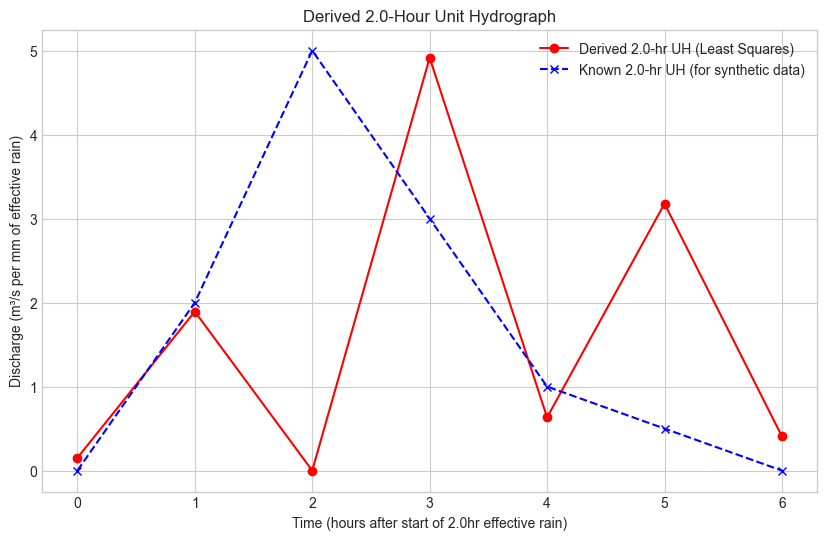

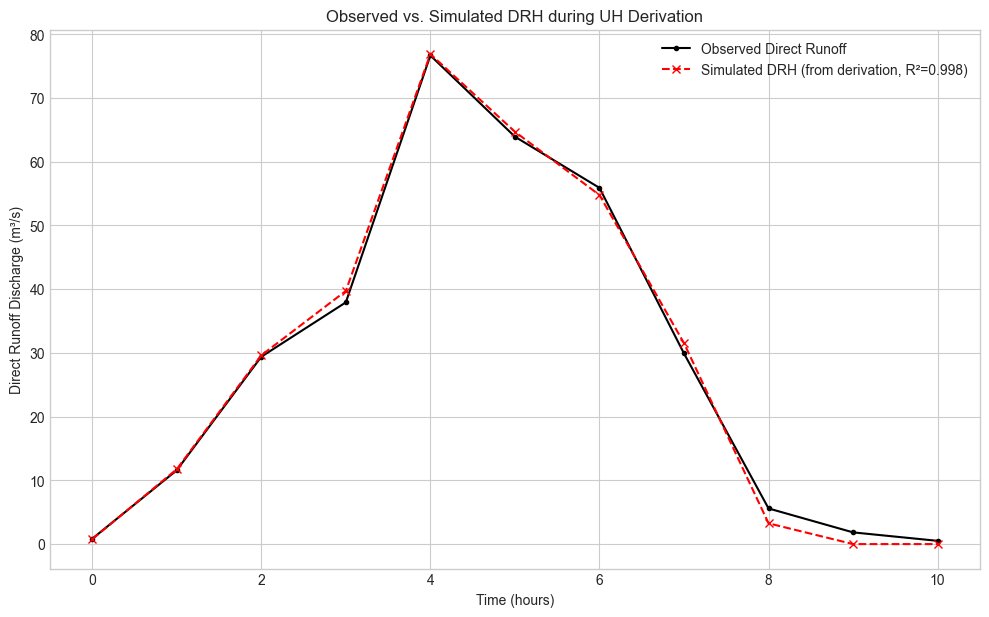


Applying the DERIVED UH to the rainfall sequence: [ 5. 15.  8.] mm


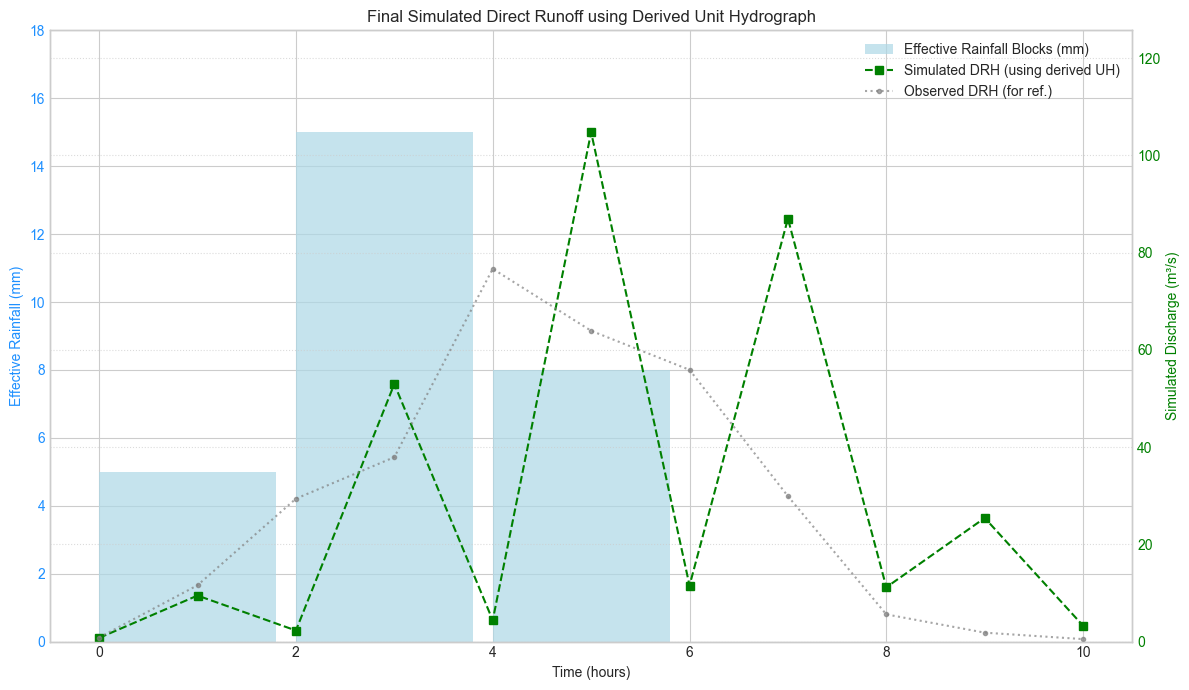

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper function to construct the rainfall convolution matrix A ---
def construct_rainfall_matrix(effective_rainfall_blocks, num_uh_ordinates, num_drh_ordinates_to_match):
    """
    Constructs the rainfall matrix 'A' for the equation A * U = Q.

    Args:
        effective_rainfall_blocks (np.array): Sequence of effective rainfall depths (P_i).
                                              Each block corresponds to one D-hour period.
        num_uh_ordinates (int): The number of ordinates (k) in the unit hydrograph (U).
        num_drh_ordinates_to_match (int): The number of observed direct runoff ordinates (n_obs)
                                          we are trying to match. This determines rows in A.

    Returns:
        np.array: The rainfall matrix A.
    """
    m = len(effective_rainfall_blocks) # Number of rainfall blocks
    k = num_uh_ordinates
    n_obs = num_drh_ordinates_to_match

    A = np.zeros((n_obs, k))

    for i_row_q in range(n_obs): # For each Q_obs ordinate (0 to n_obs-1)
        for j_col_u in range(k): # For each u ordinate (0 to k-1)
            # Q[i_row_q] = P[i_row_q - j_col_u] * u[j_col_u] + ...
            # (using 0-based indexing for arrays)
            # P_index refers to the index in effective_rainfall_blocks
            p_index = i_row_q - j_col_u
            if 0 <= p_index < m:
                A[i_row_q, j_col_u] = effective_rainfall_blocks[p_index]
    return A

# --- Part 1: Derive Unit Hydrograph using Least Squares ---
def derive_unit_hydrograph_least_squares(observed_direct_runoff,
                                         effective_rainfall_blocks,
                                         num_uh_ordinates_to_solve,
                                         time_step_hours,
                                         D_hour_duration_for_UH # Needed for time axis of UH
                                         ):
    """
    Derives a unit hydrograph using the least squares method.
    Assumes effective_rainfall_blocks are for D_hour_duration_for_UH periods.

    Args:
        observed_direct_runoff (np.array): Observed Direct Runoff Hydrograph (Q_obs).
        effective_rainfall_blocks (np.array): Sequence of effective rainfall depths (P_i).
        num_uh_ordinates_to_solve (int): The desired number of ordinates (k) for the UH.
        time_step_hours (float): Time step of the hydrograph data in hours.
        D_hour_duration_for_UH (float): The D-duration of the unit hydrograph.

    Returns:
        np.array: Ordinates of the derived Unit Hydrograph (m³/s per mm).
        np.array: Time axis for the UH.
        float: R-squared value for the fit.
        np.array: Simulated DRH using the derived UH for the input rainfall.
    """
    n_obs_points = len(observed_direct_runoff)
    m_rain_blocks = len(effective_rainfall_blocks)

    # The resulting DRH from m rain blocks and k UH ordinates has m+k-1 points.
    # We will fit to the available observed_direct_runoff points.
    # If n_obs_points < m_rain_blocks + num_uh_ordinates_to_solve - 1,
    # the system is overdetermined for the later part of Q_obs or A needs truncation.
    # We'll use up to n_obs_points for fitting.
    
    # num_drh_ordinates_to_match should be min(n_obs_points, m_rain_blocks + num_uh_ordinates_to_solve - 1)
    # or simply n_obs_points if we assume Q_obs covers the relevant period.
    # For robustness, we use n_obs_points, and Q_obs should ideally be long enough.

    A = construct_rainfall_matrix(effective_rainfall_blocks,
                                  num_uh_ordinates_to_solve,
                                  n_obs_points)

    # Solve A * U = Q_obs for U using least squares
    # `lstsq` returns: solution, residuals, rank, singular_values
    U_solution, residuals, rank, s = np.linalg.lstsq(A, observed_direct_runoff, rcond=None)

    # Unit hydrograph ordinates should not be negative. Clip them.
    # More advanced methods (e.g., non-negative least squares) could be used here.
    UH_ordinates = np.maximum(0, U_solution)

    time_axis_uh = np.arange(len(UH_ordinates)) * time_step_hours # Time relative to start of D-hr rain

    # Calculate R-squared for goodness of fit
    Q_simulated_for_fit = A @ UH_ordinates # Using the (potentially clipped) UH
    ss_res = np.sum((observed_direct_runoff - Q_simulated_for_fit)**2)
    ss_tot = np.sum((observed_direct_runoff - np.mean(observed_direct_runoff))**2)
    if ss_tot == 0: # Avoid division by zero if observed_direct_runoff is flat
        r_squared = 1.0 if ss_res == 0 else 0.0
    else:
        r_squared = 1 - (ss_res / ss_tot)
        
    # Also return the Q_simulated_for_fit for direct comparison
    return UH_ordinates, time_axis_uh, r_squared, Q_simulated_for_fit


# --- Part 2: Apply Unit Hydrograph to Simulate Runoff (Convolution) ---
# This function is similar to the one in the previous answer.
def apply_unit_hydrograph_convolution(unit_hydrograph_ordinates,
                                      effective_rainfall_blocks,
                                      time_step_hours,
                                      uh_D_duration_hours):
    """
    Applies the unit hydrograph to a sequence of effective rainfall blocks
    to simulate the direct runoff hydrograph using convolution.
    This is essentially Q_sim = A_full * U, where A_full would be built for
    the full length m+k-1.

    Args:
        unit_hydrograph_ordinates (np.array): Ordinates of the Unit Hydrograph (m³/s/mm).
        effective_rainfall_blocks (np.array): Sequence of effective rainfall depths (mm)
                                             for consecutive UH duration blocks.
        time_step_hours (float): Time step of the UH and rainfall data (hours).
        uh_D_duration_hours (float): The duration (D) for which the UH is defined
                                   and the duration of each effective rainfall block.

    Returns:
        np.array: Ordinates of the simulated Direct Runoff Hydrograph (m³/s).
        np.array: Time axis for the simulated DRH.
    """
    num_rain_blocks = len(effective_rainfall_blocks)
    len_uh = len(unit_hydrograph_ordinates)

    # The full length of the simulated DRH will be: num_rain_blocks + len_uh - 1
    # if using standard convolution product length.
    # The number of steps corresponding to one D-hour duration block
    steps_per_D_block = int(uh_D_duration_hours / time_step_hours)
    if steps_per_D_block == 0: steps_per_D_block = 1 # Should not happen if D >= time_step

    # Length of the resulting DRH from explicit superposition:
    simulated_drh_len = (num_rain_blocks - 1) * steps_per_D_block + len_uh
    simulated_drh = np.zeros(simulated_drh_len)

    for i, p_eff_block in enumerate(effective_rainfall_blocks):
        if p_eff_block > 0:
            scaled_uh = unit_hydrograph_ordinates * p_eff_block
            start_index = i * steps_per_D_block
            end_index = start_index + len_uh
            # Ensure we don't write past the end of simulated_drh if len_uh is very long
            # relative to steps_per_D_block * num_rain_blocks
            current_block_end_index = min(end_index, simulated_drh_len)
            length_to_add = current_block_end_index - start_index
            
            simulated_drh[start_index : current_block_end_index] += scaled_uh[:length_to_add]


    time_axis_sim_drh = np.arange(len(simulated_drh)) * time_step_hours
    return simulated_drh, time_axis_sim_drh


# --- Example Usage ---
# --- Define your input data here ---
time_step_h = 1.0  # Time step of all data in hours
D_duration_UH_h = 2.0 # The D-duration of the unit hydrograph (e.g., 2-hour UH)

# EXAMPLE DATA (REPLACE WITH YOUR ACTUAL DATA)
# Ensure this is EFFECTIVE rainfall, in blocks of D_duration_UH_h
# e.g., for a 6-hour storm with a 2-hour UH:
# P_eff_0_to_2h, P_eff_2_to_4h, P_eff_4_to_6h
effective_rain_blocks = np.array([5.0, 15.0, 8.0]) # mm of net rain in consecutive D-hour blocks

# Ensure this is OBSERVED DIRECT RUNOFF (baseflow removed)
# Its length should be adequate, typically >= len(effective_rain_blocks) + num_UH_ordinates - 1
# Let's create synthetic observed DRH for this example from a known UH
known_UH_for_synthetic_data = np.array([0, 2, 5, 3, 1, 0.5, 0]) # m3/s/mm (k=7)
num_UH_ordinates_actual = len(known_UH_for_synthetic_data)

# Generate "observed" DRH by convolving known_UH with effective_rain_blocks
synthetic_observed_DRH, _ = apply_unit_hydrograph_convolution(
    known_UH_for_synthetic_data,
    effective_rain_blocks,
    time_step_h,
    D_duration_UH_h
)
# Add some noise to make it more realistic for derivation
noise_level = 0.1 * np.mean(synthetic_observed_DRH[synthetic_observed_DRH > 0]) # 10% of mean positive flow
noise = np.random.normal(0, noise_level, len(synthetic_observed_DRH))
observed_DRH_example = np.maximum(0, synthetic_observed_DRH + noise) # m³/s

# --- Step 1: Derive the Unit Hydrograph using Least Squares ---
# We need to decide/estimate how many ordinates our UH should have.
# Let's try to solve for num_UH_ordinates_actual (which is 7 in this synthetic case)
num_UH_ordinates_to_estimate = 7 # Try to estimate this many ordinates for the UH.

print(f"Deriving a {D_duration_UH_h}-hour Unit Hydrograph with {num_UH_ordinates_to_estimate} ordinates...")

try:
    derived_UH_ordinates, time_UH, r2_fit, Q_sim_during_fit = derive_unit_hydrograph_least_squares(
        observed_DRH_example,
        effective_rain_blocks,
        num_UH_ordinates_to_estimate,
        time_step_h,
        D_duration_UH_h
    )

    print(f"Derived UH Ordinates (m³/s per mm): {derived_UH_ordinates}")
    print(f"R-squared of fit during derivation: {r2_fit:.4f}")

    # Plot the derived Unit Hydrograph
    plt.figure(figsize=(10, 6))
    plt.plot(time_UH, derived_UH_ordinates, marker='o', linestyle='-', color='red', label=f'Derived {D_duration_UH_h}-hr UH (Least Squares)')
    if 'known_UH_for_synthetic_data' in locals(): # If we have the true UH for comparison
        time_known_UH = np.arange(len(known_UH_for_synthetic_data)) * time_step_h
        plt.plot(time_known_UH, known_UH_for_synthetic_data, marker='x', linestyle='--', color='blue', label=f'Known {D_duration_UH_h}-hr UH (for synthetic data)')
    plt.title(f'Derived {D_duration_UH_h}-Hour Unit Hydrograph')
    plt.xlabel(f'Time (hours after start of {D_duration_UH_h}hr effective rain)')
    plt.ylabel('Discharge (m³/s per mm of effective rain)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the observed DRH vs. simulated DRH from the derivation process
    plt.figure(figsize=(12, 7))
    time_observed_DRH = np.arange(len(observed_DRH_example)) * time_step_h
    time_sim_fit = np.arange(len(Q_sim_during_fit)) * time_step_h

    plt.plot(time_observed_DRH, observed_DRH_example, marker='.', linestyle='-', color='black', label='Observed Direct Runoff')
    plt.plot(time_sim_fit, Q_sim_during_fit, marker='x', linestyle='--', color='red', label=f'Simulated DRH (from derivation, R²={r2_fit:.3f})')
    plt.title('Observed vs. Simulated DRH during UH Derivation')
    plt.xlabel('Time (hours)')
    plt.ylabel('Direct Runoff Discharge (m³/s)')
    plt.legend()
    plt.grid(True)
    plt.show()


    # --- Step 2: (Optional) Apply the DERIVED UH to a new (or same) rainfall event ---
    # For this example, let's apply it to the same rainfall to see the full convolution
    print(f"\nApplying the DERIVED UH to the rainfall sequence: {effective_rain_blocks} mm")
    simulated_DRH_final, time_sim_DRH_final = apply_unit_hydrograph_convolution(
        derived_UH_ordinates,
        effective_rain_blocks, # Can be the same or a new sequence
        time_step_h,
        D_duration_UH_h
    )

    # Plot the new effective rainfall and the simulated DRH
    fig, ax1 = plt.subplots(figsize=(12, 7))
    rain_time_axis_starts = np.arange(len(effective_rain_blocks)) * D_duration_UH_h
    ax1.bar(rain_time_axis_starts, effective_rain_blocks,
            width=D_duration_UH_h*0.9, align='edge', label='Effective Rainfall Blocks (mm)', color='lightblue', alpha=0.7)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Effective Rainfall (mm)', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='dodgerblue')
    ax1.set_ylim(0, max(effective_rain_blocks) * 1.2 if len(effective_rain_blocks) > 0 else 10)

    ax2 = ax1.twinx()
    ax2.plot(time_sim_DRH_final, simulated_DRH_final, marker='s', linestyle='--', color='green', label='Simulated DRH (using derived UH)')
    # Optionally plot observed again for comparison
    ax2.plot(time_observed_DRH, observed_DRH_example, marker='.', linestyle=':', color='grey', alpha=0.7, label='Observed DRH (for ref.)')
    ax2.set_ylabel('Simulated Discharge (m³/s)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, max(max(simulated_DRH_final), max(observed_DRH_example)) * 1.2 if len(simulated_DRH_final) > 0 else 10)

    plt.title('Final Simulated Direct Runoff using Derived Unit Hydrograph')
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

except np.linalg.LinAlgError as e:
    print(f"Linear algebra error during least squares: {e}")
    print("This can happen if the rainfall matrix A is singular or ill-conditioned.")
    print("Check your input data, especially effective rainfall and number of UH ordinates to estimate.")
except ValueError as e:
    print(f"Value error: {e}")

正在推求对应 10.0毫米 净雨的 2.0小时 单位线，包含 7 个纵坐标...
推求的 10.0mm 单位线纵坐标: [0.21042893 1.33416677 0.79129608 4.61057161 0.92153801 2.82146416
 0.69811204]
(参考：推求的 1mm 单位线纵坐标: [0.02104289 0.13341668 0.07912961 0.46105716 0.0921538  0.28214642
 0.0698112 ])
推求过程中的拟合R平方值 (基于1mm UH的拟合): 0.9947


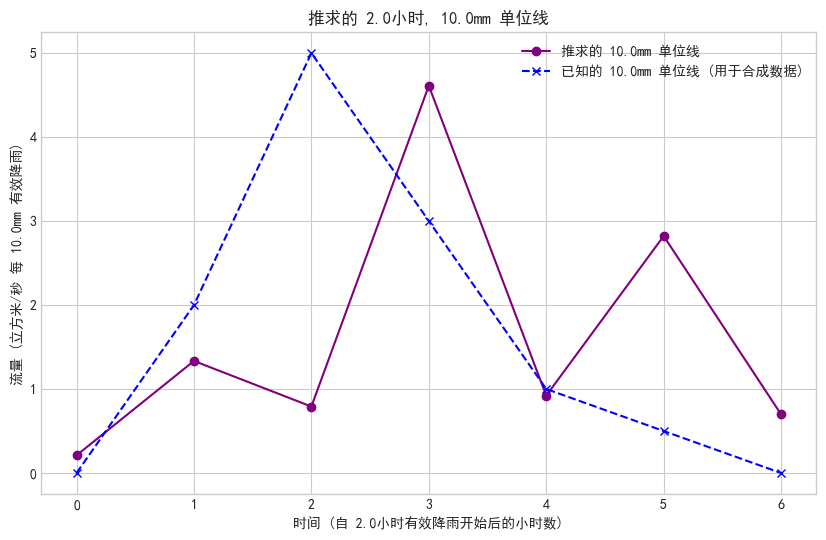

d:\Anaconda\envs\condaenvironment\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


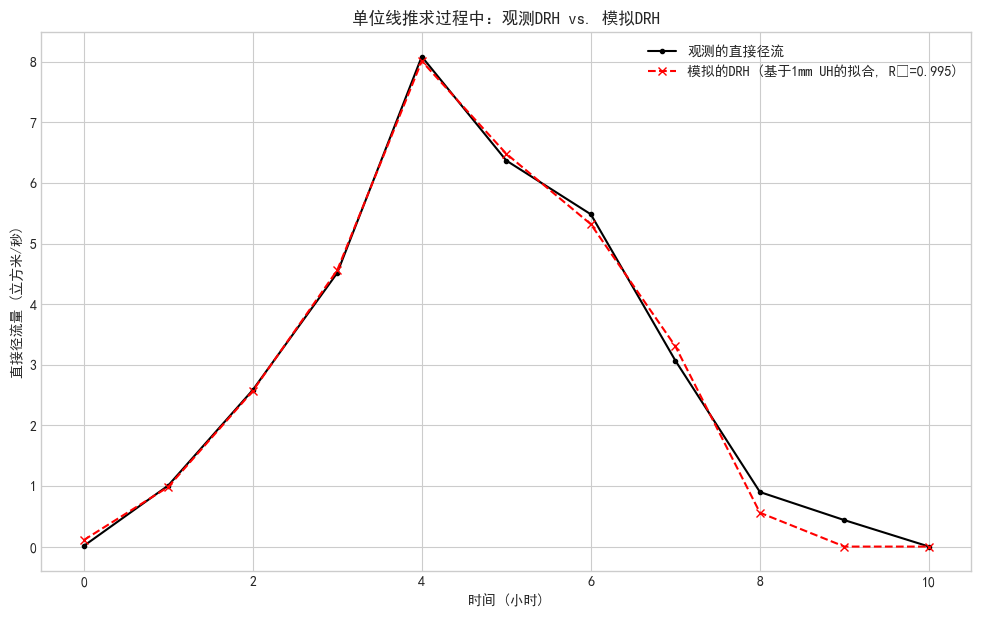


将推求的 10.0mm 单位线应用于降雨序列: [ 5. 15.  8.] 毫米


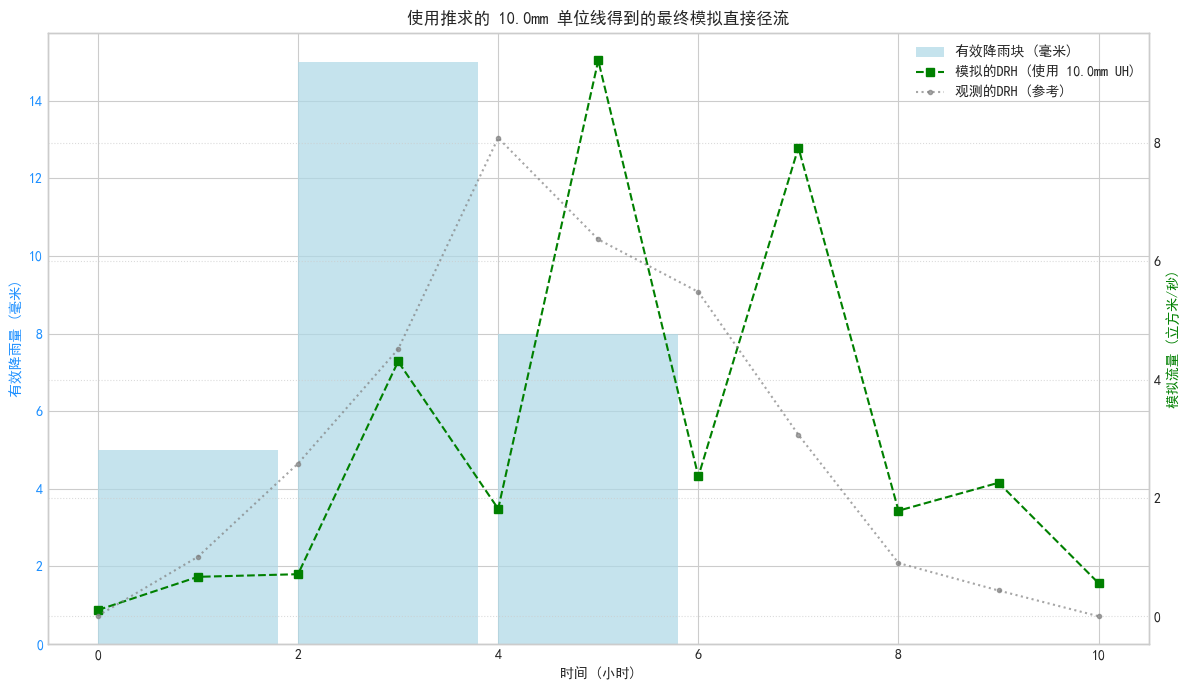

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 辅助函数：构建降雨卷积矩阵 A ---
# (此函数保持不变)
def construct_rainfall_matrix(effective_rainfall_blocks, num_uh_ordinates, num_drh_ordinates_to_match):
    m = len(effective_rainfall_blocks)
    k = num_uh_ordinates
    n_obs = num_drh_ordinates_to_match
    A = np.zeros((n_obs, k))
    for i_row_q in range(n_obs):
        for j_col_u in range(k):
            p_index = i_row_q - j_col_u
            if 0 <= p_index < m:
                A[i_row_q, j_col_u] = effective_rainfall_blocks[p_index]
    return A

# --- 第1部分：使用最小二乘法推求单位线 ---
def derive_unit_hydrograph_least_squares(observed_direct_runoff,
                                         effective_rainfall_blocks,
                                         num_uh_ordinates_to_solve,
                                         time_step_hours,
                                         D_hour_duration_for_UH,
                                         target_uh_rainfall_depth_mm=1.0 # 新增参数，目标单位线的净雨深度
                                         ):
    """
    使用最小二乘法推求单位线。

    参数:
        ... (同前) ...
        target_uh_rainfall_depth_mm (float): 希望最终得到的单位线对应的净雨深度（例如1.0或10.0毫米）。

    返回:
        np.array: 推求出的目标单位线纵坐标 (例如，如果target是10mm，则为 立方米/秒 每10毫米有效降雨)。
        np.array: 单位线的时间轴。
        float: 拟合的R平方值。
        np.array: 使用推求的1mm标准单位线对输入降雨模拟得到的DRH（用于拟合评估）。
        np.array: 推求出的1mm标准单位线纵坐标（用于内部或高级应用）。
    """
    n_obs_points = len(observed_direct_runoff)
    A = construct_rainfall_matrix(effective_rainfall_blocks,
                                  num_uh_ordinates_to_solve,
                                  n_obs_points)

    U_solution_normalized, residuals, rank, s = np.linalg.lstsq(A, observed_direct_runoff, rcond=None)
    UH_ordinates_normalized_1mm = np.maximum(0, U_solution_normalized) # 这是对应1mm净雨的单位线

    # 将1mm单位线调整到目标净雨深度
    UH_ordinates_target = UH_ordinates_normalized_1mm * target_uh_rainfall_depth_mm

    time_axis_uh = np.arange(len(UH_ordinates_target)) * time_step_hours

    # R平方值仍然基于1mm单位线与实际降雨的拟合，因为这是最小二乘法的直接结果
    Q_simulated_for_fit = A @ UH_ordinates_normalized_1mm
    ss_res = np.sum((observed_direct_runoff - Q_simulated_for_fit)**2)
    ss_tot = np.sum((observed_direct_runoff - np.mean(observed_direct_runoff))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else (1.0 if ss_res == 0 else 0.0)
        
    return UH_ordinates_target, time_axis_uh, r_squared, Q_simulated_for_fit, UH_ordinates_normalized_1mm


# --- 第2部分：应用单位线模拟径流 (卷积) ---
def apply_unit_hydrograph_convolution(unit_hydrograph_ordinates, # 这是目标单位线，比如10mm单位线
                                      effective_rainfall_blocks,
                                      time_step_hours,
                                      uh_D_duration_hours,
                                      uh_defined_for_rainfall_depth_mm # 该单位线是为多少毫米净雨定义的
                                      ):
    """
    将单位线应用于一系列有效降雨块，通过卷积模拟直接径流过程线。

    参数:
        unit_hydrograph_ordinates (np.array): 单位线的纵坐标。
        effective_rainfall_blocks (np.array): 连续的D时段有效降雨深度序列 (毫米)。
        time_step_hours (float): UH和降雨数据的时间步长 (小时)。
        uh_D_duration_hours (float): 单位线的D时段历时。
        uh_defined_for_rainfall_depth_mm (float): 输入的 unit_hydrograph_ordinates 是为多少毫米净雨定义的
                                                  (例如，如果是10mm单位线，则此值为10.0)。
    返回:
        np.array: 模拟的直接径流过程线的纵坐标 (立方米/秒)。
        np.array: 模拟DRH的时间轴。
    """
    num_rain_blocks = len(effective_rainfall_blocks)
    len_uh = len(unit_hydrograph_ordinates)
    steps_per_D_block = int(uh_D_duration_hours / time_step_hours)
    if steps_per_D_block == 0: steps_per_D_block = 1

    simulated_drh_len = (num_rain_blocks - 1) * steps_per_D_block + len_uh
    simulated_drh = np.zeros(simulated_drh_len)

    if uh_defined_for_rainfall_depth_mm <= 0:
        raise ValueError("单位线定义的净雨深度 (uh_defined_for_rainfall_depth_mm) 必须大于0。")

    for i, p_eff_block in enumerate(effective_rainfall_blocks): # p_eff_block 是实际发生的净雨
        if p_eff_block > 0:
            # 倍比系数 = 实际净雨 / 单位线定义的净雨
            scaling_factor = p_eff_block / uh_defined_for_rainfall_depth_mm
            scaled_uh_component = unit_hydrograph_ordinates * scaling_factor # 这是由p_eff_block产生的径流部分

            start_index = i * steps_per_D_block
            end_index = start_index + len_uh
            current_block_end_index = min(end_index, simulated_drh_len)
            length_to_add = current_block_end_index - start_index
            
            simulated_drh[start_index : current_block_end_index] += scaled_uh_component[:length_to_add]

    time_axis_sim_drh = np.arange(len(simulated_drh)) * time_step_hours
    return simulated_drh, time_axis_sim_drh


# --- 示例用法 ---
time_step_h = 1.0
D_duration_UH_h = 2.0
TARGET_UH_DEPTH_MM = 10.0 # 我们希望得到一个10毫米单位线

effective_rain_blocks = np.array([5.0, 15.0, 8.0]) # 毫米

# --- 合成观测数据 (与之前类似，但基于1mm标准UH生成) ---
known_UH_1mm_for_synthetic_data = np.array([0, 0.2, 0.5, 0.3, 0.1, 0.05, 0]) # 这是1mm标准UH
synthetic_observed_DRH, _ = apply_unit_hydrograph_convolution(
    known_UH_1mm_for_synthetic_data, # 使用1mm UH
    effective_rain_blocks,
    time_step_h,
    D_duration_UH_h,
    uh_defined_for_rainfall_depth_mm=1.0 # 指明这个UH是1mm的
)
noise_level = 0.02 * np.mean(synthetic_observed_DRH[synthetic_observed_DRH > 0])
noise = np.random.normal(0, noise_level, len(synthetic_observed_DRH))
observed_DRH_example = np.maximum(0, synthetic_observed_DRH + noise)

num_UH_ordinates_to_estimate = len(known_UH_1mm_for_synthetic_data)

print(f"正在推求对应 {TARGET_UH_DEPTH_MM}毫米 净雨的 {D_duration_UH_h}小时 单位线，包含 {num_UH_ordinates_to_estimate} 个纵坐标...")

try:
    # 推求单位线，目标是10mm
    derived_UH_10mm_ordinates, time_UH, r2_fit, Q_sim_during_fit, derived_UH_1mm_ordinates = \
        derive_unit_hydrograph_least_squares(
            observed_DRH_example,
            effective_rain_blocks,
            num_UH_ordinates_to_estimate,
            time_step_h,
            D_duration_UH_h,
            target_uh_rainfall_depth_mm=TARGET_UH_DEPTH_MM # 关键：指明目标是10mm
    )

    print(f"推求的 {TARGET_UH_DEPTH_MM}mm 单位线纵坐标: {derived_UH_10mm_ordinates}")
    print(f"(参考：推求的 1mm 单位线纵坐标: {derived_UH_1mm_ordinates})")
    print(f"推求过程中的拟合R平方值 (基于1mm UH的拟合): {r2_fit:.4f}")

    # 绘制推求的10mm单位线
    plt.figure(figsize=(10, 6))
    plt.plot(time_UH, derived_UH_10mm_ordinates, marker='o', linestyle='-', color='purple', label=f'推求的 {TARGET_UH_DEPTH_MM}mm 单位线')
    if 'known_UH_1mm_for_synthetic_data' in locals():
        known_UH_10mm_for_synthetic_data = known_UH_1mm_for_synthetic_data * TARGET_UH_DEPTH_MM
        time_known_UH = np.arange(len(known_UH_10mm_for_synthetic_data)) * time_step_h
        plt.plot(time_known_UH, known_UH_10mm_for_synthetic_data, marker='x', linestyle='--', color='blue', label=f'已知的 {TARGET_UH_DEPTH_MM}mm 单位线 (用于合成数据)')
    plt.title(f'推求的 {D_duration_UH_h}小时, {TARGET_UH_DEPTH_MM}mm 单位线')
    plt.xlabel(f'时间 (自 {D_duration_UH_h}小时有效降雨开始后的小时数)')
    plt.ylabel(f'流量 (立方米/秒 每 {TARGET_UH_DEPTH_MM}mm 有效降雨)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 绘制观测DRH与推求过程中模拟的DRH (基于1mm UH的拟合)
    plt.figure(figsize=(12, 7))
    time_observed_DRH = np.arange(len(observed_DRH_example)) * time_step_h
    time_sim_fit = np.arange(len(Q_sim_during_fit)) * time_step_h
    plt.plot(time_observed_DRH, observed_DRH_example, marker='.', linestyle='-', color='black', label='观测的直接径流')
    plt.plot(time_sim_fit, Q_sim_during_fit, marker='x', linestyle='--', color='red', label=f'模拟的DRH (基于1mm UH的拟合, R²={r2_fit:.3f})')
    plt.title('单位线推求过程中：观测DRH vs. 模拟DRH')
    plt.xlabel('时间 (小时)')
    plt.ylabel('直接径流量 (立方米/秒)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 应用推求出的10mm单位线 ---
    print(f"\n将推求的 {TARGET_UH_DEPTH_MM}mm 单位线应用于降雨序列: {effective_rain_blocks} 毫米")
    simulated_DRH_final, time_sim_DRH_final = apply_unit_hydrograph_convolution(
        derived_UH_10mm_ordinates, # 使用10mm单位线
        effective_rain_blocks,
        time_step_h,
        D_duration_UH_h,
        uh_defined_for_rainfall_depth_mm=TARGET_UH_DEPTH_MM # 关键：指明这个UH是10mm的
    )

    # 绘制结果
    fig, ax1 = plt.subplots(figsize=(12, 7))
    # ... (绘图部分与之前类似，确保标签正确) ...
    rain_time_axis_starts = np.arange(len(effective_rain_blocks)) * D_duration_UH_h
    ax1.bar(rain_time_axis_starts, effective_rain_blocks,
            width=D_duration_UH_h*0.9, align='edge', label='有效降雨块 (毫米)', color='lightblue', alpha=0.7)
    ax1.set_xlabel('时间 (小时)')
    ax1.set_ylabel('有效降雨量 (毫米)', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='dodgerblue')
    # ...

    ax2 = ax1.twinx()
    ax2.plot(time_sim_DRH_final, simulated_DRH_final, marker='s', linestyle='--', color='green', label=f'模拟的DRH (使用 {TARGET_UH_DEPTH_MM}mm UH)')
    ax2.plot(time_observed_DRH, observed_DRH_example, marker='.', linestyle=':', color='grey', alpha=0.7, label='观测的DRH (参考)')
    ax2.set_ylabel('模拟流量 (立方米/秒)', color='green')
    # ...
    plt.title(f'使用推求的 {TARGET_UH_DEPTH_MM}mm 单位线得到的最终模拟直接径流')
    fig.tight_layout()
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()


except np.linalg.LinAlgError as e:
    print(f"最小二乘法计算时发生线性代数错误: {e}")
except ValueError as e:
    print(f"数值错误: {e}")